In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision = 3, suppress = True)

### Параметри для генерування часового ряду або читання даних з файлів

In [373]:
READ_FROM_FILE = True

if READ_FROM_FILE:
    a, b = [], []
    with open('./test.txt') as fin:
        for line in fin:
            coef = line.strip().split('=')
            if coef[0].startswith('a'):
                a.append(float(coef[1]))
            if coef[0].startswith('b'):
                b.append(float(coef[1]))
    y = np.loadtxt('./y.txt')
    v = np.loadtxt('./v.txt')
    gen_order = (len(a), len(b))
    N = len(y)
else:
    gen_order = (3, 3)          # порядок моделі
    a = [0, 0.22, -0.18, 0.08]  # коефіцієнти АР
    b = [0.5, 0.25, 0.25]       # коефіцієнти КС
    N = 100                     # кількість згенерованих значень

### Функція для генерування часового ряду

In [374]:
def make_series(a_coef, b_coef, order, n, mov_avg, noise_std = 0):
    mov_avg = mov_avg[-n-order[1]:]
    y = [0]*order[0]
    for k in range(n):
        y.append(
            a_coef[0] +
            sum([a_coef[j]*y[order[0]+k-j] for j in range(1, order[0]+1)]) +
            mov_avg[order[1]+k] + 
            sum([b_coef[j-1]*mov_avg[order[1]+k-j] for j in range(1, order[1]+1)]) +
            np.random.randn()*noise_std
        )
    return np.array(y[order[0]:])

### Власне генерування часового ряду та його візуалізація

In [375]:
if not READ_FROM_FILE: 
    np.random.seed(42)
    v = np.random.randn(N+gen_order[1])
    y = make_series(a_coef = a, b_coef = b, 
                    order = gen_order, n = N,
                    mov_avg = v, noise_std = 0.5)

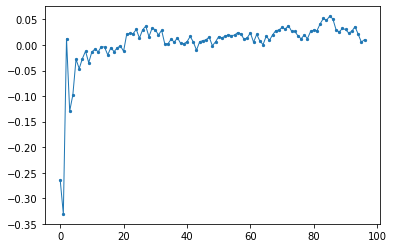

In [376]:
plt.plot(y, lw = 1)
plt.scatter(np.arange(N), y, s = 5)

### Функція для створення матриці спостережень X

In [377]:
def create_X(y, v, order = (3, 3)):
    N = min(len(y)-order[0], len(v)-order[1])
    X = np.zeros((N, 2+order[0]+order[1]))
    X[:, 0] = np.ones((N, ))
    for j in range(order[0]):
        X[:, order[0]-j] = y[j:N+j]
    for j in range(order[1]+1):
        X[:, order[0]+order[1]-j+1] = v[j:N+j]
    return X

### МНК

In [378]:
def LS(X, y):
    coefs_history = []
    for i in range(len(y)):
        X_temp = X[:i+1]
        y_temp = y[:i+1]
        coefs_history.append(
            np.linalg.pinv(X_temp.T @ X_temp) @ X_temp.T @ y_temp
        )
    return coefs_history

### РМНК

In [379]:
def RLS(X, y):
    n = X.shape[1]
    theta = np.zeros((n, 1))
    coefs_history = [theta.flatten()]
    P = 1e5 * np.eye(n)
    for i in range(len(y)):
        x = X[i].reshape((n, 1))
        temp = P @ x / (1 + x.T @ P @ x)
        theta += temp * (y[i] - x.T @ theta)
        coefs_history.append(theta.flatten())
        P = P - temp @ x.T @ P
    return coefs_history

### Функції для обчислення метрик моделі

In [380]:
# сума квадратів похибок
def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

# коефіцієнт детермінації R^2
def r_squared(y_true, y_pred):
    n = y_true.size
    return 1 - sum_squared_error(y_true, y_pred) / (n*y_true.var())

# значення критерію Акайке
def akaike(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] +1
    N = y_true.size 
    return N * np.log(sum_squared_error(y_true,y_pred)) + 2*n

### Задання порядку моделі, яка буде шукатися

In [381]:
ARMA = (3, 3)

### Створення матриці X та вигляд її перших 5 рядків

In [382]:
X = create_X(y, v[ARMA[1]:], ARMA)

In [383]:
X[:5]

array([[ 1.   ,  0.013, -0.331, -0.264,  0.984,  0.464,  0.268,  0.789],
       [ 1.   , -0.129,  0.013, -0.331, -0.552,  0.984,  0.464,  0.268],
       [ 1.   , -0.098, -0.129,  0.013,  0.902, -0.552,  0.984,  0.464],
       [ 1.   , -0.028, -0.098, -0.129,  0.19 ,  0.902, -0.552,  0.984],
       [ 1.   , -0.046, -0.028, -0.098,  1.168,  0.19 ,  0.902, -0.552]])

### Знаходження коефіцієнтів за допомогою МНК та їх оцінювання

In [384]:
LS_history = LS(X, y[gen_order[0]:])
res_LS = LS_history[-1]
res_LS[ARMA[0]+1] = 1

In [385]:
res_LS

array([ 0.006,  0.212,  0.326,  0.03 ,  1.   ,  0.002,  0.001, -0.001])

In [386]:
y_LS = make_series(a_coef = res_LS[:ARMA[0]+1], b_coef = res_LS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v)

In [387]:
print('S =', sum_squared_error(y, y_LS))
print('R^2 =', r_squared(y, y_LS))
print('IKA =', akaike(y, y_LS, ARMA))

S = 127.53733033810157
R^2 = -502.8109856705999
IKA = 484.29568354489373


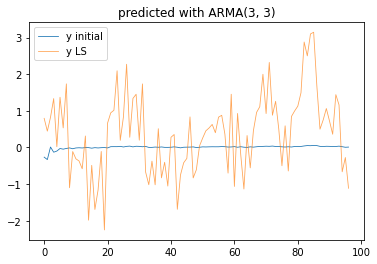

In [388]:
plt.plot(y, label = 'y initial', lw = 0.8)
plt.plot(y_LS, label = 'y LS', lw = 0.8, alpha = 0.7)
plt.title('predicted with ARMA' + f'{ARMA}')
plt.legend()

### Знаходження коефіцієнтів за допомогою РМНК та їх оцінювання

In [389]:
RLS_history = RLS(X, y[gen_order[0]:])
res_RLS = RLS_history[-1]
#res_RLS[ARMA[1]+1] = 1

In [390]:
res_RLS

array([ 0.006,  0.212,  0.326,  0.03 ,  0.011,  0.002,  0.001, -0.001])

In [391]:
y_RLS = make_series(a_coef = res_RLS[:ARMA[0]+1], b_coef = res_RLS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v)

In [392]:
print('S =', sum_squared_error(y, y_RLS))
print('R^2 =', r_squared(y, y_RLS))
print('IKA =', akaike(y, y_RLS, ARMA))

S = 127.5188687460208
R^2 = -502.7380568043722
IKA = 484.2816413499469


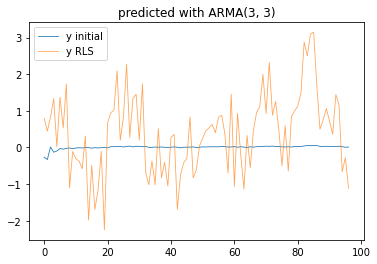

In [393]:
plt.plot(y, label = 'y initial', lw = 0.8)
plt.plot(y_RLS, label = 'y RLS', lw = 0.8, alpha = 0.7)
plt.title('predicted with ARMA' + f'{ARMA}')
plt.legend()